# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


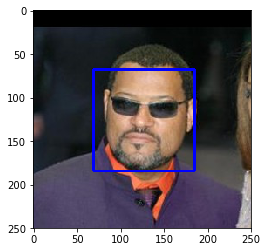

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [16]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path, cascade_classifier):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = cascade_classifier.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

As per the code snippet below, 99% of human faces were detected in the human 100-sample dataset, and 11% of human faces were detected in the dog 100-sample dataset. This a good rate for the human dataset and not-that-great rate for the dog dataset. However, we can still obtain quite accurate results with such datasets. 

In [17]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_faces_counter = 0

for i in human_files_short:
    if face_detector(i, face_cascade):
        human_faces_counter += 1
        
# Since we check for 100 images, the counter is the ratio
print("In 100 human images ", human_faces_counter, "% human faces were detected.")

human_faces_counter = 0

for j in dog_files_short:
    if face_detector(j, face_cascade):
        human_faces_counter += 1  
        
print("In 100 dog images ", human_faces_counter, "% human faces were detected.")

In 100 human images  99 % human faces were detected.
In 100 dog images  11 % human faces were detected.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

At this point, our algorithm will work only with clear face pictures as input and won't perform well otherwise. This is not too bad since most of the users will use their camera to take a simple picture of a face and thus they will automatically realize if a picture is blurry or inappropriate to use. They can still use such a picture and get approximate results, and choose to try again with a better picture. 

If we trully want to address is and improve the user experience, we should work on alternative specialized version of the algorithm (other OpenCV choices for cascading) to better detect human faces regardless their quality and context. 

See another example below with the default frontal face cascade classifier. As you will see, this classifier is too eager to classify human faces: 100% of human faces will be detected in the human set, and 60% of human faces will be detected in the dog dataset.

We can keep trying more OpenCV classifiers until we are happy with the results. Explore more here:
https://github.com/opencv/opencv/tree/master/data

In [13]:
# Consider the following version of face_detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

human_faces_counter = 0

for i in human_files_short:
    if alternative_face_detector(i, face_cascade):
        human_faces_counter += 1
        
# Since we check for 100 images, the counter is the ratio
print("In 100 human images ", human_faces_counter, "% human faces were detected.")

human_faces_counter = 0

for j in dog_files_short:
    if alternative_face_detector(j, face_cascade):
        human_faces_counter += 1  
        
print("In 100 dog images ", human_faces_counter, "% human faces were detected.")

In 100 human images  100 % human faces were detected.
In 100 dog images  60 % human faces were detected.


For the purpsoses of this application, we are going to stick with the face_detector that uses the haarcascade frontalface alt classifier:

In [18]:
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [19]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [20]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [21]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [22]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

As you can see in the results of the code snippet below, by using the ResNet50 predictor inside the dog_detector, we get pretty impressive results. In particular:

- Percentage of human faces in dog dataset:  1.0 %
- Percentage of dog faces in dog dataset:  100.0 %

In [23]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_counter = 0

for i in human_files_short:
    if dog_detector(i):
        dog_counter += 1
        
print("Percentage of dog detected faces in human dataset: ", dog_counter, "%")

dog_counter = 0

for j in dog_files_short:
    if dog_detector(j):
        dog_counter += 1
        
print("Percentage of dog detected faces in dog dataset: ", dog_counter, "%")

Percentage of dog detected faces in human dataset:  1 %
Percentage of dog detected faces in dog dataset:  100 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [24]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████| 836/836 [00:14<00:00, 76.78it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

I choose to follow the suggested architecture -- but I will also experiment with slight variations of it and examine changes in the results. 

- The chosen model is Sequential: **model = Sequential()** *[See more here: https://keras.io/models/sequential/]*


I will start with the input layer that receives processed pictures of 224x224 pixels as input of 16 dimensions. Furthermore, I choose a ReLU (Rectified Linear Unit) for the activation function, and I set the padding to be valid, the stride length to be 2, and the kerner size (length of 1D convolution window) to be 5. Using Keras that would look like:


- model.add(Conv2D(filters=16,kernel_size=(5,5),strides=(2,2),padding='valid',activation='relu',input_shape=(224,224,3)))


Then, I will add a max pooling 2D layer with no stride lenght, valid padding, and pool size 3x3:

- model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))


Then, following the suggested architecture, I will add the following layers as per the indicated order described above, and extend this suggestion by

1) adding a dropout rate right before the last layer, which indicates what fraction of neurons should be "ignored" during training -- my choice is 20%, selected randomly. 

2) Add another MaxPooling layer

Thus, the complete model I am using is:

- model.add(**Conv2D**(filters=16,kernel_size=(5,5),strides=(2,2),padding='valid',activation='relu',input_shape=(224,224,3)))
- model.add(**MaxPooling2D**(pool_size=(3, 3), strides=None, padding='valid'))
- model.add(**Conv2D**(filters = 32, kernel_size = (5,5), strides = (4,4), padding = 'valid', activation = 'relu'))
- model.add(**MaxPooling2D**(pool_size=(3, 3), strides=None, padding='valid'))
- model.add(**MaxPooling2D**(pool_size=2))
- model.add(**GlobalAveragePooling2D**())
- model.add(**Dropout**(0.2))
- model.add(**Dense**(len(**dog_names**), activation='softmax'))

Notice that the last layer (output) should be dense with nodes as many as the dog names, using a softmax activation function that can handle higher dimensions for input.

As per the documentation:

*nD tensor with shape: (batch_size, ..., units). For instance, for a 2D input with shape  (batch_size, input_dim), the output would have shape (batch_size, units).*

Source: https://keras.io/layers/core/


**Alternative Architectures** 

We can try different architectures by simply adding/removing layers in the network. Another architecture for example would be (only describing the layers):

- **Conv2D**
- **Conv2D**
- **MaxPooling2D**
- **Conv2D**
- **Conv2D**
- **GlobalAveragePooling2D**
- **Dropout(0.X)** 
- **Dense**

Another way modify the network is to play with the parameters. Although the architecture will remain the same (same layers) the results will vary depending on the parameter changes. Some of these changes include:

- **Activation function** (ReLU or Softmax or tanh etc.) *see more here: https://keras.io/activations/*
- **Kernel Size**
- **filters**
- **strides**
- **padding**


with the following characterizations:


- filters:     Integer, the dimensionality of the output space (i.e. the number output of filters in the convolution)
- kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
- strides:     An integer or tuple/list of a single integer, specifying the stride length of the convolution.
- padding:     One of "valid", "causal" or "same"
- activation:  Activation function to use. If you don't specify anything, no activation is applied


In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

# Architecture (see answer to question 4 for explanation)

model.add(Conv2D(filters=16,kernel_size=(5,5),strides=(2,2),padding='valid',activation='relu',input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (4,4), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(len(dog_names), activation='softmax'))

# Model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

### Compile the Model

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [27]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

# Assume 8 epochs (iterations)
# I chose this number after doing some small research online 
# and looking at plots of number of epochs vs MSE and Loss. 
# It seems that a good approximation is > 5 and less < 10 in our case
# In order to save some computational time, I decided on epochs = 8
epochs = 8

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 4.86396, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00001: val_loss improved from 4.86396 to 4.79797, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00002: val_loss improved from 4.79797 to 4.73807, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00003: val_loss improved from 4.73807 to 4.70961, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00004: val_loss improved from 4.70961 to 4.65733, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00005: val_loss improved from 4.65733 to 4.58775, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00006: val_loss improved from 4.58775 to 4.54463, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 00007: val_loss improved from 4.54463 to 4.48996, saving model to saved_models/weights.best.from_scratch.hdf5


### Load the Model with the Best Validation Loss

In [28]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [29]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.7847%


The test accuracy is indeed greater than 1%. As we will see below, we are going to use transfer learning to to train the CNN and reduce computational time without sacrificing accuracy.

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [30]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [31]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [32]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [33]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 10.72428, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00001: val_loss improved from 10.72428 to 9.95285, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00002: val_loss improved from 9.95285 to 9.79562, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00003: val_loss improved from 9.79562 to 9.52335, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00004: val_loss improved from 9.52335 to 9.30053, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00005: val_loss improved from 9.30053 to 9.22173, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00006: val_loss improved from 9.22173 to 9.18021, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00007: val_loss improved from 9.18021 to 8.90563, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00008: val_loss improved from 8.90563 to 8.61328, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 00009: val_loss

### Load the Model with the Best Validation Loss

In [34]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [35]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 44.0191%


### Predict Dog Breed with the Model

In [36]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [37]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I chose the InceptionV3 model here since it is the latest addition of Tensorflow (https://www.tensorflow.org/tutorials/image_recognition, https://arxiv.org/abs/1512.00567) and seems to be working pretty good. 

In addition, I decided to implement the standard InceptionV3 architecture which starts with a global average pooling, a dense layer (I chose 500 nodes, but that could vary), a dropout rate of 30% to avoid overfitting, then another dense layer of 1000 nodes this time, followed by another dropout rate of 20% this time, and finally an output layer with softmax activation function. Notice that I choose an l2 regularizer with 0.01 and 0.02 parameters, which describes an l2 penalty.

I believe this architecture is going to work well here since it has been tested successfully in the past and is a reliable model for image classification. Another advantage that is useful in our case is that InceptionV3 does an excellent job on reducing dimensionality and thus makes the calculations faster. 

See more details about the InceptionV3 model here: https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/


===================================================================================

### Trial and Error

In order to test my assumptions above, I will perform the following tests and compare results to conclude in an "optimal" set of parameters and architecture, under the InceptionV3 model.

#### Test 1

##### Architecture

- inception_model = Sequential()
- GlobalAveragePooling2D
- Dense
- Dropout
- Dense
- Dropout
- Dense

##### Parameters

- GlobalAveragePooling2D(**input_shape=input_array**)
- Dense(**500, activation='relu', kernel_regularizer=regularizers.l2(0.01)**)
- Dropout(**0.3**)
- Dense(**1000, activation='relu', kernel_regularizer=regularizers.l2(0.02)**)
- Dropout(**0.2**)
- Dense(**len(dog_names), activation='softmax')**)
- Adamax(**0.02**)
- Epochs = 12
- Batch Size = 32

##### Results

Model accuracy: *68.06%* 
Speed: *Too slow*

The model's accuracy is still greater than 60%, but let's see if we can do better by changing the parameters, keeping the same architecture.


#### Test 2

##### Architecture

- inception_model = Sequential()
- GlobalAveragePooling2D
- Dense
- Dropout
- Dense
- Dropout
- Dense

##### Parameters

- GlobalAveragePooling2D(**input_shape=input_array**)
- Dense(**500, activation='relu', kernel_regularizer=regularizers.l2(0.0001)**)
- Dropout(**0.4**)
- Dense(**200, activation='relu', kernel_regularizer=regularizers.l2(0.0002)**)
- Dropout(**0.2**)
- Dense(**len(dog_names), activation='softmax')**)
- Adamax(**0.0002**)
- Epochs = 12
- Batch Size = 32

##### Results

Model accuracy: *82.53%*
Speed: *Slightly faster, but still slow*

With the above parameter tuning we improved results by ~21%. Let's perform one more test and see if it can get better than this, or at least faster. In the following test I am removing one dense and one dropout layer, and I increase the remaining Dense parameter to 800. Moreover, I decrease the remaining dropout parameter to 25%.


#### Test 3

##### Architecture

- inception_model = Sequential()
- GlobalAveragePooling2D
- Dense
- Dropout
- Dense

##### Parameters

- GlobalAveragePooling2D(**input_shape=input_array**)
- Dense(**800, activation='relu', kernel_regularizer=regularizers.l2(0.0001)**)
- Dropout(**0.25**)
- Dense(**len(dog_names), activation='softmax')**)
- Adamax(**0.0002**) 
- Epochs = 12
- Batch Size = 32

##### Results

Model accuracy: *82.89%*
Speed: *faster than before*

Now the accuracy has indeed increased a little and the training was a bit faster. In the following last experiment, I will keep this final architecture with some further parameter tuning and see what happens.


#### Test 4

##### Architecture

- inception_model = Sequential()
- GlobalAveragePooling2D
- Dense
- Dropout
- Dense

##### Parameters

- GlobalAveragePooling2D(**input_shape=input_array**)
- Dense(**900, activation='relu', kernel_regularizer=regularizers.l2(0.001)**)
- Dropout(**0.3**)
- Dense(**len(dog_names), activation='softmax')**)
- Adamax(**0.002**) 
- Epochs = 15
- Batch Size = 60

##### Results

Model accuracy: *83.04%*
Speed: *Much faster than before -- almost half computational time*

Now the accuracy increased a little more, but as we see below the number of epochs chosen was kind of uneccesarily big. Nevertheless, by keep tuning the model or even change some of the parameters (Adam instead of Adamax for example) might improve the results even better. 

In [38]:
### TODO: Define your architecture.
from keras import regularizers

input_array = train_InceptionV3.shape[1:]
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=input_array))
inception_model.add(Dense(900, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
inception_model.add(Dropout(0.3))
inception_model.add(Dense(len(dog_names), activation='softmax'))

inception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 900)               1844100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 900)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               119833    
Total params: 1,963,933.0
Trainable params: 1,963,933.0
Non-trainable params: 0.0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [39]:
### TODO: Compile the model.
from keras.optimizers import Adam, Adamax

## Adamax is a variant of Adam based on the infinity norm
## Adam is an algorithm for first-order gradient-based optimization of stochastic objective function

inception_model.compile(loss='categorical_crossentropy', optimizer=Adamax(lr=0.002), metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [40]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

# Make the model parameters generic
no_epochs = 15 # Not much improvement after 15 epochs
bsize = 60

inception_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=no_epochs, batch_size=bsize, callbacks=[checkpointer], verbose=0)

Epoch 00000: val_loss improved from inf to 1.69200, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00001: val_loss improved from 1.69200 to 1.50859, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00002: val_loss improved from 1.50859 to 1.39555, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00003: val_loss improved from 1.39555 to 1.27802, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00004: val_loss improved from 1.27802 to 1.21829, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00005: val_loss improved from 1.21829 to 1.14780, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00006: val_loss improved from 1.14780 to 1.07762, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00007: val_loss improved from 1.07762 to 1.07610, saving model to saved_models/weights.best.InceptionV3.hdf5
Epoch 00008: val_loss improved from 1.07610 to 1.02279, saving model to saved_models

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [69]:
### Load the model weights with the best validation loss.
inception_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [44]:
### TODO: Calculate classification accuracy on the test dataset.
InceptionV3_predictions = [np.argmax(inception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print("Test accuracy: ", test_accuracy * 100, "%")

Test accuracy:  83.014354067 %


The accuracy is greater than 60% !

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

Breed:  Border_terrier
Breed:  Beagle
Breed:  Akita
Breed:  Bulldog
Breed:  Dalmatian
The function currently predicts  100.0 % of the breeds


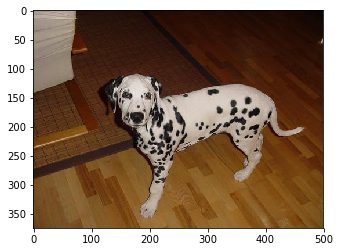

In [45]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def InceptionV3_predict_breed(image_path):
    
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(image_path))
    
    # obtain predicted vector
    predicted_vector = inception_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(image_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    
    if dog_detector(image_path):
        print("Breed: ", breed)
    else:
        print("If this person were a dog, would be a ", breed)
        
    return breed


# Test the function

percentage = []

# Breed = Border Terrier
if InceptionV3_predict_breed('dogImages/test/030.Border_terrier/Border_terrier_02096.jpg') == 'Border_terrier':
    percentage.append(1)
else:
    percentage.append(0)

# Breed = Beagle
if InceptionV3_predict_breed('dogImages/test/016.Beagle/Beagle_01141.jpg') == 'Beagle':
    percentage.append(1)
else:
    percentage.append(0)

# Breed = Akita
if InceptionV3_predict_breed('dogImages/test/004.Akita/Akita_00263.jpg') == 'Akita':
    percentage.append(1)
else:
    percentage.append(0)

# Breed = Bulldog
if InceptionV3_predict_breed('dogImages/test/040.Bulldog/Bulldog_02828.jpg') == 'Bulldog':
    percentage.append(1)
else:
    percentage.append(0)

# Breed = Dalmatian
if InceptionV3_predict_breed('dogImages/test/057.Dalmatian/Dalmatian_04056.jpg') == 'Dalmatian':
    percentage.append(1)
else:
    percentage.append(0)
    
correct_ratio = 100 * sum(percentage) / len(percentage)

print("The function currently predicts ", correct_ratio, "% of the breeds")

Looking at the outputs, the function correctly predicted 100% of the breeds!

Let's test the function with some more **"difficult" images** of dogs.

Difficult in this case means:

- More objects in the picture (i.e. a human, a tree, etc.)
- Similar-color background
- Longer distance from the camera
- Dog image captured in a rotated angle

Breed:  Border_terrier
Breed:  Basset_hound
Breed:  Akita
Breed:  Bulldog
Breed:  English_setter
The function currently predicts  75.0 % of the breeds


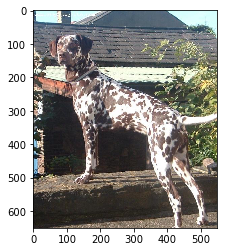

In [46]:
# More testing

percentage2 = []

# Breed = Border Terrier
if InceptionV3_predict_breed('dogImages/test/030.Border_terrier/Border_terrier_02096.jpg') == 'Border_terrier':
    percentage2.append(1)
else:
    percentage2.append(0)

# Breed = Beagle
if InceptionV3_predict_breed('dogImages/test/016.Beagle/Beagle_01156.jpg') == 'Beagle':
    percentage2.append(1)
else:
    percentage2.append(0)

# Breed = Akita
if InceptionV3_predict_breed('dogImages/test/004.Akita/Akita_00282.jpg') == 'Akita':
    percentage2.append(1)
else:
    percentage2.append(0)

# Breed = Bulldog
if InceptionV3_predict_breed('dogImages/test/040.Bulldog/Bulldog_02835.jpg') == 'Bulldog':
    percentage2.append(1)
else:
    percentage2.append(0)

# Breed = Dalmatian
if InceptionV3_predict_breed('dogImages/test/057.Dalmatian/Dalmatian_04059.jpg') == 'Dalmatian':
    percentage.append(1)
else:
    percentage.append(0)
    
correct_ratio = 100 * sum(percentage2) / len(percentage2)

print("The function currently predicts ", correct_ratio, "% of the breeds")

The function performs with 75% correctness in the "hard" image cases. For example, it confuses a Beagle with a basset hound and an English Setter with a Dalmatian. These breeds are very similar to each other, so at least our algorithm is not doing terribly.

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [57]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def Inception_Predictor(image_path):
    
    # Use CNN from step 5
    bottleneck_feature = extract_InceptionV3(path_to_tensor(image_path))
    predicted_vector = inception_model.predict(bottleneck_feature)
    
    # Find the most likely dog breed
    breed = dog_names[np.argmax(predicted_vector)]
    
    # Format image to print
    img = cv2.imread(image_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Check if the dog_detector detects a dog
    if dog_detector(image_path):
        print("Dog found!")
        imgplot = plt.imshow(cv_rgb)
        print("Breed: ", breed)
        return breed
        
    # Check if the human_detector detects a human face
    # If not, print an error message and return void
    if face_detector(image_path, face_cascade):
        print("Human found!")
        imgplot = plt.imshow(cv_rgb)
        print("This person looks like a ", breed)
        return breed
    else:
        print("Neither dog or human found!\nPlease provide a picture of a dog or human.")
        return None
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

The algorithm works pretty well in most cases. For the most part the results are satisfying and it looks like the CNN is doing a good job recognizing the breeds and if there is a human or not in the picture. For more unclear pictures, there might be trouble as we saw above, but if we want to improve the results we can do so in the following ways:

1) Parameter tuning: find optimal set of parameters in the network 

2) Model Architectures: find the optimal network structure (how many layers, max poolings, dropouts, etc.)

3) Optimizers: find an optimizer that optimizes the propagation process best 

4) Number of epochs (training stopping time): find the best number of network iterations that give best results on time

5) OpenCV face cascade for the application: test many of them and see which works best 


Overall I am happy with the results, however I would work a bit more on this (following the above list of steps to optimize further) if I wanted to deploy this as a web or mobile application.

Human found!
This person looks like a  Dachshund


'Dachshund'

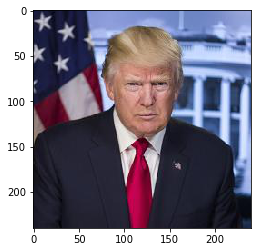

In [58]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# Test 1 : Donald Trump
Inception_Predictor('images/myImgs/trump.jpg')

Human found!
This person looks like a  Dachshund


'Dachshund'

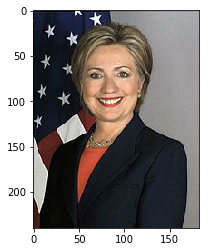

In [60]:
# Test 3 : Hilary Clinton
Inception_Predictor('images/myImgs/hilary.jpg')

In [61]:
# Test 3 : Some cat
Inception_Predictor('images/myImgs/cat.jpg')

Neither dog or human found!
Please provide a picture of a dog or human.


Dog found!
Breed:  Great_dane


'Great_dane'

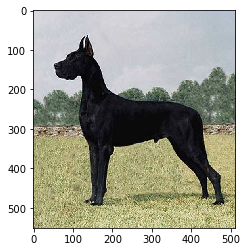

In [62]:
# Test 3 : Great Dane
Inception_Predictor('images/myImgs/GreatDane.jpg')

Dog found!
Breed:  Beagle


'Beagle'

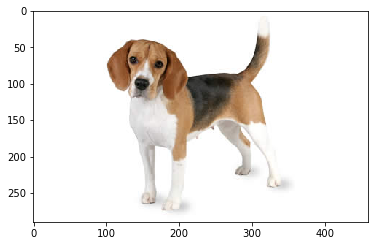

In [65]:
# Test 3 : Beagle
Inception_Predictor('images/myImgs/beagle.jpg')

Dog found!
Breed:  Chihuahua


'Chihuahua'

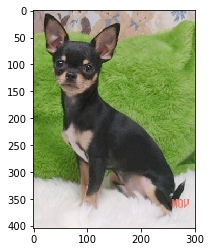

In [64]:
# Test 3 : Chihuahua
Inception_Predictor('images/myImgs/chihuahua.jpg')

Dog found!
Breed:  German_shepherd_dog


'German_shepherd_dog'

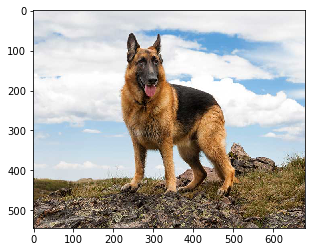

In [66]:
# Test 3 : German Sheperd
Inception_Predictor('images/myImgs/shep.jpg')

Human found!
This person looks like a  Dachshund


'Dachshund'

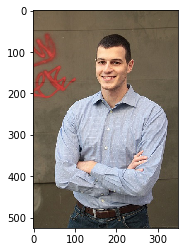

In [67]:
# Test 3 : Me
Inception_Predictor('images/myImgs/me.jpg')

Human found!
This person looks like a  Icelandic_sheepdog


'Icelandic_sheepdog'

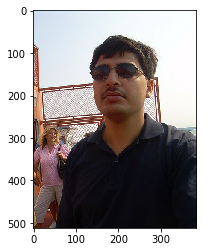

In [68]:
# Test 3 : My professor
Inception_Predictor('images/myImgs/shir.jpg')